# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

 9519104/11490434 [=======================>......] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:13 - loss: 0.6940

  26/1875 [..............................] - ETA: 3s - loss: 0.5521   

  53/1875 [..............................] - ETA: 3s - loss: 0.4705

  80/1875 [>.............................] - ETA: 3s - loss: 0.4282

 108/1875 [>.............................] - ETA: 3s - loss: 0.4002

 134/1875 [=>............................] - ETA: 3s - loss: 0.3814

 161/1875 [=>............................] - ETA: 3s - loss: 0.3661

 186/1875 [=>............................] - ETA: 3s - loss: 0.3545

 211/1875 [==>...........................] - ETA: 3s - loss: 0.3446

 238/1875 [==>...........................] - ETA: 3s - loss: 0.3354

 266/1875 [===>..........................] - ETA: 3s - loss: 0.3269

 294/1875 [===>..........................] - ETA: 3s - loss: 0.3194

 322/1875 [====>.........................] - ETA: 2s - loss: 0.3127

 350/1875 [====>.........................] - ETA: 2s - loss: 0.3067

 380/1875 [=====>........................] - ETA: 2s - loss: 0.3008

 409/1875 [=====>........................] - ETA: 2s - loss: 0.2956

 436/1875 [=====>........................] - ETA: 2s - loss: 0.2911

 463/1875 [======>.......................] - ETA: 2s - loss: 0.2870

 490/1875 [======>.......................] - ETA: 2s - loss: 0.2831

 511/1875 [=======>......................] - ETA: 2s - loss: 0.2802

 539/1875 [=======>......................] - ETA: 2s - loss: 0.2766

 566/1875 [========>.....................] - ETA: 2s - loss: 0.2734

 591/1875 [========>.....................] - ETA: 2s - loss: 0.2705

 618/1875 [========>.....................] - ETA: 2s - loss: 0.2676

 644/1875 [=========>....................] - ETA: 2s - loss: 0.2649

 666/1875 [=========>....................] - ETA: 2s - loss: 0.2627

 691/1875 [==========>...................] - ETA: 2s - loss: 0.2604

 721/1875 [==========>...................] - ETA: 2s - loss: 0.2577

 750/1875 [===========>..................] - ETA: 2s - loss: 0.2552

 776/1875 [===========>..................] - ETA: 2s - loss: 0.2530

 806/1875 [===========>..................] - ETA: 2s - loss: 0.2506

 839/1875 [============>.................] - ETA: 1s - loss: 0.2482

 869/1875 [============>.................] - ETA: 1s - loss: 0.2460

 895/1875 [=============>................] - ETA: 1s - loss: 0.2442

 921/1875 [=============>................] - ETA: 1s - loss: 0.2425

 954/1875 [==============>...............] - ETA: 1s - loss: 0.2403

 986/1875 [==============>...............] - ETA: 1s - loss: 0.2383

1016/1875 [===============>..............] - ETA: 1s - loss: 0.2366

1042/1875 [===============>..............] - ETA: 1s - loss: 0.2351

1064/1875 [================>.............] - ETA: 1s - loss: 0.2338

1094/1875 [================>.............] - ETA: 1s - loss: 0.2322

1120/1875 [================>.............] - ETA: 1s - loss: 0.2308

1146/1875 [=================>............] - ETA: 1s - loss: 0.2295

1170/1875 [=================>............] - ETA: 1s - loss: 0.2283

1195/1875 [==================>...........] - ETA: 1s - loss: 0.2271

1223/1875 [==================>...........] - ETA: 1s - loss: 0.2257

1249/1875 [==================>...........] - ETA: 1s - loss: 0.2245

1277/1875 [===================>..........] - ETA: 1s - loss: 0.2233

1301/1875 [===================>..........] - ETA: 1s - loss: 0.2222

1329/1875 [====================>.........] - ETA: 1s - loss: 0.2210

1354/1875 [====================>.........] - ETA: 0s - loss: 0.2200

1383/1875 [=====================>........] - ETA: 0s - loss: 0.2188

1411/1875 [=====================>........] - ETA: 0s - loss: 0.2176

1441/1875 [======================>.......] - ETA: 0s - loss: 0.2165

1469/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1495/1875 [======================>.......] - ETA: 0s - loss: 0.2144

1524/1875 [=======================>......] - ETA: 0s - loss: 0.2134

1557/1875 [=======================>......] - ETA: 0s - loss: 0.2122

1585/1875 [========================>.....] - ETA: 0s - loss: 0.2113

1607/1875 [========================>.....] - ETA: 0s - loss: 0.2105

1634/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1666/1875 [=========================>....] - ETA: 0s - loss: 0.2086

1695/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1722/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1748/1875 [==========================>...] - ETA: 0s - loss: 0.2060

1772/1875 [===========================>..] - ETA: 0s - loss: 0.2053

1800/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1827/1875 [============================>.] - ETA: 0s - loss: 0.2037

1854/1875 [============================>.] - ETA: 0s - loss: 0.2029

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2023


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1125

  29/1875 [..............................] - ETA: 3s - loss: 0.1095

  58/1875 [..............................] - ETA: 3s - loss: 0.1098

  86/1875 [>.............................] - ETA: 3s - loss: 0.1098

 114/1875 [>.............................] - ETA: 3s - loss: 0.1099

 138/1875 [=>............................] - ETA: 3s - loss: 0.1099

 170/1875 [=>............................] - ETA: 3s - loss: 0.1098

 182/1875 [=>............................] - ETA: 3s - loss: 0.1098

 202/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 227/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 249/1875 [==>...........................] - ETA: 3s - loss: 0.1096

 273/1875 [===>..........................] - ETA: 3s - loss: 0.1095

 299/1875 [===>..........................] - ETA: 3s - loss: 0.1095

 324/1875 [====>.........................] - ETA: 3s - loss: 0.1094

 350/1875 [====>.........................] - ETA: 3s - loss: 0.1094

 372/1875 [====>.........................] - ETA: 3s - loss: 0.1093

 400/1875 [=====>........................] - ETA: 3s - loss: 0.1093

 422/1875 [=====>........................] - ETA: 2s - loss: 0.1092

 451/1875 [======>.......................] - ETA: 2s - loss: 0.1091

 474/1875 [======>.......................] - ETA: 2s - loss: 0.1091

 499/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 519/1875 [=======>......................] - ETA: 2s - loss: 0.1090

 536/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 556/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 573/1875 [========>.....................] - ETA: 2s - loss: 0.1088

 590/1875 [========>.....................] - ETA: 2s - loss: 0.1088

 612/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 633/1875 [=========>....................] - ETA: 2s - loss: 0.1087

 658/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 676/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 696/1875 [==========>...................] - ETA: 2s - loss: 0.1085

 717/1875 [==========>...................] - ETA: 2s - loss: 0.1085

 736/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 759/1875 [===========>..................] - ETA: 2s - loss: 0.1084

 787/1875 [===========>..................] - ETA: 2s - loss: 0.1083

 814/1875 [============>.................] - ETA: 2s - loss: 0.1083

 843/1875 [============>.................] - ETA: 2s - loss: 0.1082

 871/1875 [============>.................] - ETA: 2s - loss: 0.1081

 901/1875 [=============>................] - ETA: 2s - loss: 0.1081

 929/1875 [=============>................] - ETA: 2s - loss: 0.1080

 957/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 986/1875 [==============>...............] - ETA: 1s - loss: 0.1079

1017/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1045/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1071/1875 [================>.............] - ETA: 1s - loss: 0.1077

1100/1875 [================>.............] - ETA: 1s - loss: 0.1076

1129/1875 [=================>............] - ETA: 1s - loss: 0.1076

1157/1875 [=================>............] - ETA: 1s - loss: 0.1075

1180/1875 [=================>............] - ETA: 1s - loss: 0.1075

1208/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1233/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1263/1875 [===================>..........] - ETA: 1s - loss: 0.1073

1291/1875 [===================>..........] - ETA: 1s - loss: 0.1073

1320/1875 [====================>.........] - ETA: 1s - loss: 0.1072

1349/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1378/1875 [=====================>........] - ETA: 1s - loss: 0.1071

1405/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1434/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1460/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1488/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1518/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1548/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1579/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1609/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1639/1875 [=========================>....] - ETA: 0s - loss: 0.1066

1668/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1698/1875 [==========================>...] - ETA: 0s - loss: 0.1065

1728/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1758/1875 [===========================>..] - ETA: 0s - loss: 0.1064

1787/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1815/1875 [============================>.] - ETA: 0s - loss: 0.1063

1841/1875 [============================>.] - ETA: 0s - loss: 0.1062

1863/1875 [============================>.] - ETA: 0s - loss: 0.1062

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1062


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1047

  29/1875 [..............................] - ETA: 3s - loss: 0.0992

  57/1875 [..............................] - ETA: 3s - loss: 0.0984

  86/1875 [>.............................] - ETA: 3s - loss: 0.0981

 115/1875 [>.............................] - ETA: 3s - loss: 0.0979

 145/1875 [=>............................] - ETA: 3s - loss: 0.0979

 173/1875 [=>............................] - ETA: 3s - loss: 0.0979

 199/1875 [==>...........................] - ETA: 3s - loss: 0.0979

 228/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 258/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 318/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 346/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 375/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 448/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0979

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0979

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 591/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 725/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 755/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 780/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 831/1875 [============>.................] - ETA: 1s - loss: 0.0979

 856/1875 [============>.................] - ETA: 1s - loss: 0.0979

 879/1875 [=============>................] - ETA: 1s - loss: 0.0979

 906/1875 [=============>................] - ETA: 1s - loss: 0.0979

 932/1875 [=============>................] - ETA: 1s - loss: 0.0979

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1083/1875 [================>.............] - ETA: 1s - loss: 0.0979

1112/1875 [================>.............] - ETA: 1s - loss: 0.0979

1141/1875 [=================>............] - ETA: 1s - loss: 0.0979

1171/1875 [=================>............] - ETA: 1s - loss: 0.0979

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1228/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1256/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1309/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0979

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1734/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1822/1875 [============================>.] - ETA: 0s - loss: 0.0978

1851/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0977


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1042

  29/1875 [..............................] - ETA: 3s - loss: 0.0972

  58/1875 [..............................] - ETA: 3s - loss: 0.0965

  87/1875 [>.............................] - ETA: 3s - loss: 0.0962

 116/1875 [>.............................] - ETA: 3s - loss: 0.0961

 142/1875 [=>............................] - ETA: 3s - loss: 0.0960

 166/1875 [=>............................] - ETA: 3s - loss: 0.0960

 190/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 243/1875 [==>...........................] - ETA: 3s - loss: 0.0960

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 295/1875 [===>..........................] - ETA: 3s - loss: 0.0960

 321/1875 [====>.........................] - ETA: 2s - loss: 0.0960

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0960

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 403/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0960

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0960

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0960

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0960

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 660/1875 [=========>....................] - ETA: 2s - loss: 0.0960

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 717/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0960

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0960

 805/1875 [===========>..................] - ETA: 1s - loss: 0.0960

 830/1875 [============>.................] - ETA: 1s - loss: 0.0960

 854/1875 [============>.................] - ETA: 1s - loss: 0.0960

 883/1875 [=============>................] - ETA: 1s - loss: 0.0960

 916/1875 [=============>................] - ETA: 1s - loss: 0.0960

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0960

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1088/1875 [================>.............] - ETA: 1s - loss: 0.0960

1118/1875 [================>.............] - ETA: 1s - loss: 0.0960

1148/1875 [=================>............] - ETA: 1s - loss: 0.0960

1179/1875 [=================>............] - ETA: 1s - loss: 0.0960

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1524/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1818/1875 [============================>.] - ETA: 0s - loss: 0.0960

1842/1875 [============================>.] - ETA: 0s - loss: 0.0960

1864/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1014

  27/1875 [..............................] - ETA: 3s - loss: 0.0953

  48/1875 [..............................] - ETA: 4s - loss: 0.0954

  73/1875 [>.............................] - ETA: 3s - loss: 0.0955

  98/1875 [>.............................] - ETA: 3s - loss: 0.0957

 121/1875 [>.............................] - ETA: 3s - loss: 0.0958

 146/1875 [=>............................] - ETA: 3s - loss: 0.0958

 171/1875 [=>............................] - ETA: 3s - loss: 0.0958

 194/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 236/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 259/1875 [===>..........................] - ETA: 3s - loss: 0.0958

 277/1875 [===>..........................] - ETA: 3s - loss: 0.0958

 302/1875 [===>..........................] - ETA: 3s - loss: 0.0959

 326/1875 [====>.........................] - ETA: 3s - loss: 0.0958

 353/1875 [====>.........................] - ETA: 3s - loss: 0.0958

 374/1875 [====>.........................] - ETA: 3s - loss: 0.0958

 399/1875 [=====>........................] - ETA: 3s - loss: 0.0958

 421/1875 [=====>........................] - ETA: 3s - loss: 0.0958

 446/1875 [======>.......................] - ETA: 3s - loss: 0.0958

 469/1875 [======>.......................] - ETA: 3s - loss: 0.0958

 492/1875 [======>.......................] - ETA: 3s - loss: 0.0958

 515/1875 [=======>......................] - ETA: 3s - loss: 0.0958

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 694/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 718/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 747/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 771/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 800/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 829/1875 [============>.................] - ETA: 2s - loss: 0.0957

 854/1875 [============>.................] - ETA: 2s - loss: 0.0957

 882/1875 [=============>................] - ETA: 2s - loss: 0.0957

 907/1875 [=============>................] - ETA: 2s - loss: 0.0957

 929/1875 [=============>................] - ETA: 2s - loss: 0.0957

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0957

 977/1875 [==============>...............] - ETA: 1s - loss: 0.0957

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1068/1875 [================>.............] - ETA: 1s - loss: 0.0957

1090/1875 [================>.............] - ETA: 1s - loss: 0.0957

1111/1875 [================>.............] - ETA: 1s - loss: 0.0957

1134/1875 [=================>............] - ETA: 1s - loss: 0.0957

1162/1875 [=================>............] - ETA: 1s - loss: 0.0956

1182/1875 [=================>............] - ETA: 1s - loss: 0.0956

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1386/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1411/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1827/1875 [============================>.] - ETA: 0s - loss: 0.0955

1848/1875 [============================>.] - ETA: 0s - loss: 0.0955

1874/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0955


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

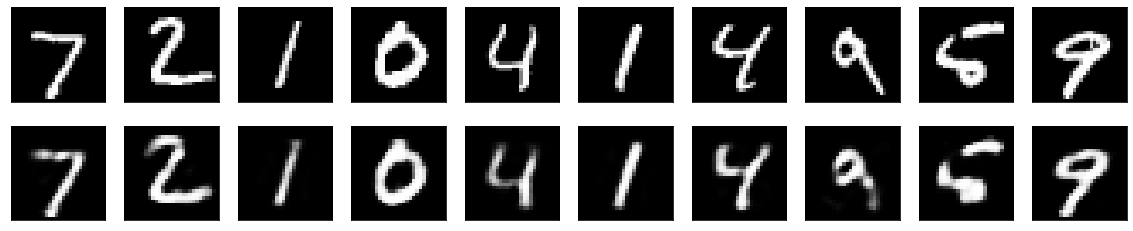

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
